In [1]:
from music21 import converter, note, chord, harmony, meter, stream
import numpy as np

def extract_lead_sheet_info(xml_path, quantization='16th', fixed_length=None):
    # Load the score and flatten
    score = converter.parse(xml_path)
    melody_part = score.parts[0].flat

    # Define 16th note length
    ql_per_16th = 0.25 / 4

    # Get pitch range: MIDI 21 (A0) to 108 (C8) -> 88 notes
    pitch_range = list(range(21, 109))
    n_pitch = len(pitch_range)

    # Step 1: Find first chord symbol and bar to trim before it
    first_chord_offset = None
    for el in melody_part.recurse().getElementsByClass(harmony.ChordSymbol):
        first_chord_offset = el.offset
        break

    measure_start_offset = 0.0
    if first_chord_offset is not None:
        for meas in melody_part.getElementsByClass(stream.Measure):
            if meas.offset <= first_chord_offset < meas.offset + meas.duration.quarterLength:
                measure_start_offset = meas.offset
                break

    skip_steps = int(np.round(measure_start_offset / ql_per_16th))

    # Determine total length in 16th notes
    total_duration_q = melody_part.highestTime
    total_steps = int(np.ceil(total_duration_q / ql_per_16th))

    # Allocate raw matrices (we will trim/pad later)
    raw_pianoroll = np.zeros((total_steps, n_pitch), dtype=np.uint8)
    raw_chords = [None] * total_steps

    # Fill pianoroll
    for el in melody_part.notesAndRests:
        start = int(np.round(el.offset / ql_per_16th))
        dur_steps = int(np.round(el.quarterLength / ql_per_16th))

        if isinstance(el, note.Note):
            midi = el.pitch.midi
            if midi in pitch_range:
                idx = pitch_range.index(midi)
                raw_pianoroll[start:start+dur_steps, idx] = 1

        elif isinstance(el, chord.Chord):  # Just in case
            for pitch in el.pitches:
                midi = pitch.midi
                if midi in pitch_range:
                    idx = pitch_range.index(midi)
                    raw_pianoroll[start:start+dur_steps, idx] = 1

    # Fill chord grid
    for el in melody_part.recurse().getElementsByClass(harmony.ChordSymbol):
        start = int(np.round(el.offset / ql_per_16th))
        if 0 <= start < len(raw_chords):
            raw_chords[start] = el.figure

    # Propagate chord forward
    for i in range(1, len(raw_chords)):
        if raw_chords[i] is None:
            raw_chords[i] = raw_chords[i-1]

    # Fill missing with <pad> or <nc>
    for i in range(len(raw_chords)):
        if raw_chords[i] is None:
            raw_chords[i] = "<nc>"  # Or use "<pad>" if preferred

    # Trim to start at first chord bar
    raw_pianoroll = raw_pianoroll[skip_steps:]
    raw_chords = raw_chords[skip_steps:]

    # Add pitch class profile (top 12 dims)
    n_steps = len(raw_pianoroll)
    pitch_classes = np.zeros((n_steps, 12), dtype=np.uint8)
    for i in range(n_steps):
        pitch_indices = np.where(raw_pianoroll[i] > 0)[0]
        for idx in pitch_indices:
            midi = pitch_range[idx]
            pitch_classes[i, midi % 12] = 1
    full_pianoroll = np.hstack([pitch_classes, raw_pianoroll])  # Shape: (T, 12 + 88)

    # Apply fixed length (pad or trim)
    if fixed_length is not None:
        if n_steps > fixed_length:
            full_pianoroll = full_pianoroll[:fixed_length]
            raw_chords = raw_chords[:fixed_length]
        elif n_steps < fixed_length:
            pad_len = fixed_length - n_steps
            pad_pr = np.zeros((pad_len, full_pianoroll.shape[1]), dtype=np.uint8)
            pad_ch = ["<pad>"] * pad_len
            full_pianoroll = np.vstack([full_pianoroll, pad_pr])
            raw_chords += pad_ch

    return full_pianoroll, raw_chords


In [2]:
import os
root_dir = '/media/maindisk/maximos/data/hooktheory_train/'

for dirpath, _, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml'):
            full_path = os.path.join(dirpath, file)
            break
print(full_path)

pianoroll, chord_seq = extract_lead_sheet_info(full_path, fixed_length=256)

print("Pianoroll shape:", pianoroll.shape)  # (256, 100) -> 12 pitch class + 88 piano roll
print("Chord seq length:", len(chord_seq))  # Should match T
print("Chord at step 0:", chord_seq[0])


/media/maindisk/maximos/data/hooktheory_train/h/haim/dont-save-me/chorus.xml
Pianoroll shape: (256, 100)
Chord seq length: 256
Chord at step 0: Em


/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [3]:
print(len(chord_seq))
print(chord_seq)

256
['Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'Em', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am', 'Am

In [4]:
from MLMDif_tokenizers import CSMLMDifTokenizer

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
tokenizer = CSMLMDifTokenizer(fixed_length=256)

In [6]:
x = tokenizer.encode(full_path)

/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [7]:
print(x['input_ids'])
print(x['input_tokens'])
print(x['pianoroll'].shape)
print(len(x['attention_mask']))
print(x['time_signature'])

[123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
from models import MLMDifMelHarm

In [9]:
model = MLMDifMelHarm(chord_vocab_size=len(tokenizer.vocab), conditioning_dim=16)

In [10]:
from data_utils import CSMLMDifDataset, CSMLMDif_collate_fn
from torch.utils.data import DataLoader

In [11]:
train_dir = '/media/maindisk/maximos/data/hooktheory_train'
train_dataset = CSMLMDifDataset(train_dir, tokenizer, 512)

In [12]:
x = train_dataset[0]
print(x['input_ids'])

[6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 296, 296, 296, 296, 296, 296, 296, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 151, 151, 151, 151, 151, 151, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 296, 296, 296, 296, 296, 296, 296, 151, 151, 151, 151, 151, 151, 151, 151, 151, 6, 6, 6

In [13]:
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=CSMLMDif_collate_fn)

In [14]:
batch = next(iter(trainloader))

In [15]:
print(batch['input_ids'].shape)
print(batch['pianoroll'].shape)

torch.Size([8, 256])
torch.Size([8, 256, 100])


In [16]:
y = model( batch['time_signature'].to(model.device), batch['pianoroll'].to(model.device) )

In [17]:
print(y.shape)

torch.Size([8, 256, 354])


In [18]:
import torch
import random
from tqdm import tqdm

import torch

def apply_structured_masking(harmony_tokens, mask_token_id, step_idx, spacing_schedule):
    """
    harmony_tokens: (B, 256) - original ground truth tokens
    mask_token_id: int - ID for the special <mask> token
    step_idx: int - 0, 1, 2, etc.
    spacing_schedule: list[int] - e.g., [16, 8, 4]

    Returns:
        masked_harmony: (B, 256) with some tokens replaced with <mask>
        target_harmony: (B, 256) with -100 at positions we do NOT want loss
    """
    B, T = harmony_tokens.shape
    assert T == 256

    device = harmony_tokens.device
    spacing = spacing_schedule[step_idx] if step_idx < len(spacing_schedule) else 1

    # Get the indices that will remain unmasked for this step
    mask = torch.ones((T,), dtype=torch.bool, device=device)  # start with all masked
    mask[::spacing] = False  # reveal tokens at spacing

    # Expand to batch
    mask = mask.unsqueeze(0).expand(B, -1)  # shape (B, 256)

    # Create masked version
    masked_harmony = harmony_tokens.clone()
    masked_harmony[mask] = mask_token_id

    # Create target (loss computed only on masked positions)
    target = harmony_tokens.clone()
    target[~mask] = -100  # ignore tokens that were shown to the model

    return masked_harmony, target


def get_step_idx_linear(epoch, epochs_per_stage, max_step_idx):
    return min(epoch // epochs_per_stage, max_step_idx)

def get_step_idx_mixed(epoch, max_epoch, max_step_idx):
    """Returns a random step index, biased toward early stages in early epochs."""
    progress = epoch / max_epoch
    probs = torch.softmax(torch.tensor([
        (1.0 - abs(progress - (i / max_step_idx))) * 5 for i in range(max_step_idx + 1)
    ]), dim=0)
    return torch.multinomial(probs, 1).item()

def train_with_curriculum(
    model, optimizer, dataloader, loss_fn,
    spacing_schedule, mask_token_id,
    epochs=10,
    curriculum_type="linear",  # "linear" or "mixed"
    epochs_per_stage=2,
):
    device = next(model.parameters()).device
    max_step_idx = len(spacing_schedule) - 1

    for epoch in range(epochs):
        model.train()

        # Determine masking level
        if curriculum_type == "linear":
            step_idx = get_step_idx_linear(epoch, epochs_per_stage, max_step_idx)
        elif curriculum_type == "mixed":
            step_idx = get_step_idx_mixed(epoch, epochs, max_step_idx)
        else:
            raise ValueError("Invalid curriculum type")

        epoch_loss = 0.0
        running_loss = 0.
        running_accuracy = 0.
        batch_num = 0
        with tqdm(trainloader, unit='batch') as tepoch:
            tepoch.set_description(f'Epoch {epoch} (step {step_idx}) | trn')
            for batch in tepoch:
                melody_grid = batch["pianoroll"].to(device)           # (B, 256, 140)
                harmony_gt = batch["input_ids"].to(device)         # (B, 256)
                conditioning_vec = batch["time_signature"].to(device)  # (B, C0)
                
                # Apply masking to harmony
                harmony_input, harmony_target = apply_structured_masking(
                    harmony_gt, mask_token_id, step_idx, spacing_schedule
                )

                # Forward pass
                logits = model(conditioning_vec, melody_grid, harmony_input)

                # Compute loss only on masked tokens
                loss = loss_fn(logits.view(-1, logits.size(-1)), harmony_target.view(-1))

                # update loss and accuracy
                batch_num += 1
                running_loss += loss.item()
                train_loss = running_loss/batch_num
                predictions = logits.argmax(dim=-1)
                mask = harmony_target != -100
                running_accuracy += (predictions[mask] == harmony_target[mask]).sum().item()/mask.sum().item()
                train_accuracy = running_accuracy/batch_num

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                tepoch.set_postfix(loss=train_loss, accuracy=train_accuracy)


In [22]:
import matplotlib.pyplot as plt

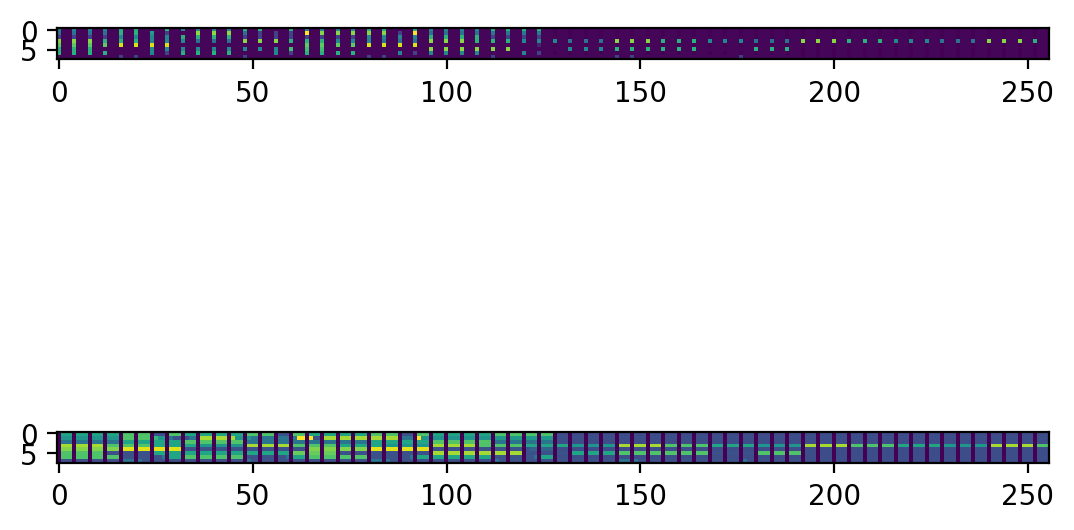

In [27]:
spacing_schedule = [16, 8, 4]
mask_token_id = tokenizer.mask_token_id  # <mask> token index
step_idx = 2

masked_harmony, target = apply_structured_masking(batch['input_ids'], mask_token_id, step_idx, spacing_schedule)
# print(masked_harmony)
# print(target)
plt.subplot(2,1,1)
plt.imshow(masked_harmony)
plt.subplot(2,1,2)
plt.imshow(target)

In [19]:
from torch.optim import AdamW
spacing_schedule = [16, 8, 4]
mask_token_id = tokenizer.mask_token_id  # <mask> token index

lr = 0.00005
optimizer = AdamW(model.parameters(), lr=lr)

train_with_curriculum(
    model=model,
    optimizer=optimizer,
    dataloader=trainloader,
    loss_fn=torch.nn.CrossEntropyLoss(ignore_index=-100),
    spacing_schedule=spacing_schedule,
    mask_token_id=mask_token_id,
    epochs=20,
    curriculum_type="mixed",  # or "linear"
    epochs_per_stage=3        # only for linear
)


Epoch 0 (step 0) | trn:   0%|          | 0/1710 [00:00<?, ?batch/s]/home/maximos/miniconda3/envs/torch/lib/python3.12/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
Epoch 0 (step 0) | trn:  42%|████▏     | 715/1710 [02:45<03:50,  4.32batch/s, accuracy=0.48, loss=2.06] 


KeyboardInterrupt: 